# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# Import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, count, when, col, desc, udf, col, sort_array, asc, \
                                  avg, from_unixtime, split, min, max, round, lit, mean
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.functions import row_number
from pyspark.sql.window import Window

from pyspark.sql.types import IntegerType, TimestampType
import datetime
from pyspark.sql.functions import to_date, year, month, dayofmonth, dayofweek, hour, date_format, substring

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb

In [2]:
# Create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

In [3]:
# Set time parser policy
spark.conf.set("spark.sql.legacy.timeParserPolicy","LEGACY")

### Common Functions

In [4]:
# Set plot's figure size
def set_plot_size(width, height):
    return plt.figure(figsize = [width, height]);

def get_user_logs(userId, sessionId=None):
    if sessionId == None:
        return data.where(data.userId == userId) \
            .select('tsDate', 'userId', 'sessionId', 'itemInSession', 'level', 'page') \
            .sort('tsDate', 'itemInSession')
    else:
        return data.where((data.userId == userId) & (data.sessionId == sessionId)) \
            .select('tsDate', 'userId', 'sessionId', 'itemInSession', 'level', 'page') \
            .sort('tsDate', 'itemInSession')

# Load and prepare Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [5]:
path = "data/mini_sparkify_event_data.json"
data = spark.read.json(path)

In [6]:
# Load dataset
path = "data/mini_sparkify_event_data.json"
data = spark.read.json(path)
original_count = data.count()

# Remove rows with missing users
data = data.where(~((col('userId').isNull()) | (col('userId') == '')))

# Exclude non-relevant columns
data = data.drop('firstName')
data = data.drop('lastName')
#data = data.drop('method')

data = data.withColumn('regDate', (col('registration') / 1000.0).cast(TimestampType()))
data = data.withColumn('tsDate', (col('ts') / 1000.0).cast(TimestampType()))
data.take(1)

data = data.withColumn('city', split(data['location'], ',')[0])
data = data.withColumn('state', split(data['location'], ',')[1])
data = data.drop('location')

# Define churned users using Cancellation Confirmation event (canceled)
query_churn_by_cc = data.where(data.page == 'Cancellation Confirmation')
print(f'Churned users who cancelled subscription: {query_churn_by_cc.count()}')

# Label churned (canceled) users
canceled = query_churn_by_cc.select('userId').dropDuplicates().select('userId')
canceled_uids = [row.userId for row in canceled.collect()];
set_churn = udf(lambda x: 1 if x in canceled_uids else 0, IntegerType())
data = data.withColumn('churn', set_churn('userId'))

# Add [userRowId] column that assigns a 1-based index to every user's log ordered by [ts]
w =  Window.partitionBy(data.userId).orderBy('ts', 'itemInSession')
data = data.withColumn('userRowId', row_number().over(w))

# Add [userRowDescId] column that assigns a 1-based index to every user's log ordered by [ts] descending.
w =  Window.partitionBy(data.userId).orderBy(col('ts').desc(), col('itemInSession').desc())
data = data.withColumn('userRowDescId', row_number().over(w))

# Add last level column
last_levels = dict()
for row in data.where(data.userRowDescId == 1).select('userId', 'level').collect():
    last_levels[row.userId] = row.level
get_level = udf(lambda userId: last_levels[userId])
data = data.withColumn('lastLevel', get_level('userId'))

Churned users who cancelled subscription: 52


In [8]:
# Query churned users by downgrade event
# Note: we fusion both types of churned users - canceled + downgraded
churned2 = data.where((data.churn == 1) \
           | ((data.page == 'Submit Downgrade') \
           & (data.lastLevel == 'free'))) \
    .select('userId') \
    .dropDuplicates()

# Label downgraded users (churn=1)
uids = [row.userId for row in churned2.collect()]
set_churn = udf(lambda userId: 1 if userId in uids else 0, IntegerType())
data = data.withColumn('churn2', set_churn('userId'))

data.printSchema()
data.take(3)

# check count of churned users
data.where(data.churn2 == 1).select('userId').dropDuplicates().count()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- regDate: timestamp (nullable = true)
 |-- tsDate: timestamp (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- churn: integer (nullable = true)
 |-- userRowId: integer (nullable = true)
 |-- userRowDescId: integer (nullable = true)
 |-- lastLevel: string (nullable = true)
 |-- churn2: integer (nullable = true)



67

#### Add churn groups totals

In [40]:
data = data.drop('total')
data = data.drop('total2')
data.take(1)

[Row(artist=None, auth='Logged In', gender='F', itemInSession=34, length=None, level='free', method='PUT', page='Logout', registration=1538016340000, sessionId=187, song=None, status=307, ts=1542823952000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', regDate=datetime.datetime(2018, 9, 27, 4, 45, 40), tsDate=datetime.datetime(2018, 11, 21, 19, 12, 32), city='Bridgeport-Stamford-Norwalk', state=' CT', churn=0, userRowId=381, userRowDescId=1, lastLevel='free', churn2=0)]

In [41]:
# Add user totals of each churn group to our dataframe
count0, count1, count20, count21 = 173, 52, 158, 67
get_churn_total = udf(lambda x: count0 if x == 0 else count1)
get_churn_total2 = udf(lambda x: count20 if x == 0 else count21)

data = data \
    .withColumn('total', get_churn_total('churn')) \
    .withColumn('total2', get_churn_total2('churn2'))
data.take(1)

[Row(artist=None, auth='Logged In', gender='F', itemInSession=34, length=None, level='free', method='PUT', page='Logout', registration=1538016340000, sessionId=187, song=None, status=307, ts=1542823952000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', regDate=datetime.datetime(2018, 9, 27, 4, 45, 40), tsDate=datetime.datetime(2018, 11, 21, 19, 12, 32), city='Bridgeport-Stamford-Norwalk', state=' CT', churn=0, userRowId=381, userRowDescId=1, lastLevel='free', churn2=0, total='173', total2='158')]

In [27]:
data.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- regDate: timestamp (nullable = true)
 |-- tsDate: timestamp (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- churn: integer (nullable = true)
 |-- userRowId: integer (nullable = true)
 |-- userRowDescId: integer (nullable = true)
 |-- lastLevel: string (nullable = true)
 |-- churn2: integer (nullable = true)
 |-- total: string (nullable = true)
 |-- total2: string (nullabl

### Session Level

In [704]:
session_stats_df = data \
    .groupby('churn', 'userId', 'sessionId') \
    .agg(count('sessionId').alias('logCount'), ((max('ts') - min('ts'))/60000).alias('duration')) \
    .groupby('churn', 'userId') \
    .agg(count('userId').alias('sessionCount'), \
         Fsum('logCount').alias('logCount'), \
         avg('duration').alias('duration')) \
    .groupby('churn') \
    .agg(avg('sessionCount').alias('avgSessionCount'), \
         avg('logCount').alias('avgLogCount'), \
         avg('duration').alias('avgDuration')) \
    .sort('churn') \
    .toPandas()

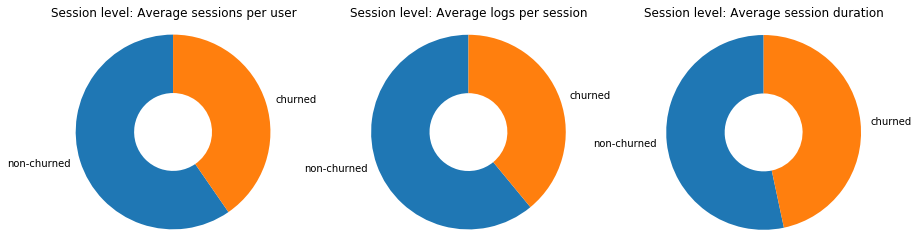

In [705]:
set_plot_size(15, 4);

# 1. Sesions per user
plt.subplot(1, 3, 1)
plt.pie(session_stats_df['avgSessionCount'], labels = ['non-churned', 'churned'], startangle = 90, \
        counterclock = True, wedgeprops = {'width' : 0.6});
plt.axis('square')
ax = plt.gca()
ax.set_title('Session level: Average sessions per user');

# 2. Logs per session
plt.subplot(1, 3, 2)
plt.pie(session_stats_df['avgLogCount'], labels = ['non-churned', 'churned'], startangle = 90, \
        counterclock = True, wedgeprops = {'width' : 0.6});
plt.axis('square')
ax = plt.gca()
ax.set_title('Session level: Average logs per session');    
    
# 3. Session duration
plt.subplot(1, 3, 3)
plt.pie(session_stats_df['avgDuration'], labels = ['non-churned', 'churned'], startangle = 90, \
        counterclock = True, wedgeprops = {'width' : 0.6});
plt.axis('square')
ax = plt.gca()
ax.set_title('Session level: Average session duration');

plt.show()

In [86]:
data.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- regDate: timestamp (nullable = true)
 |-- tsDate: timestamp (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- churn: integer (nullable = true)
 |-- userRowId: integer (nullable = true)
 |-- userRowDescId: integer (nullable = true)
 |-- lastLevel: string (nullable = true)
 |-- churn2: integer (nullable = true)
 |-- total: string (nullable = true)
 |-- total2: string (nullabl

In [98]:
# Calc duration in hours of entire observation period of a user
total_duration_df = data \
    .groupby('churn', 'userId') \
    .agg(((max('ts') - min('ts'))/1000/60/60).alias('duration')) \
    .groupby('churn') \
    .agg(round(Fsum('duration'), 1).alias('totalDuration')) \
    .toPandas()

In [ ]:
    #.select('churn', round(col('duration'), 1).alias('totalDuration')) \

In [99]:
total_duration_df

,churn,totalDuration
0,1,29346.3
1,0,195106.1


In [92]:
total_duration_df.groupby('userId').sum().sum()

totalDuration    13467144.9
dtype: float64

In [72]:
def calc_page_avg():
    return data \
        .where(~data.page.isin(['Cancel', 'Cancellation Confirmation'])) \
        .groupby('churn', 'total', 'page') \
        .count() \
        .select('churn', 'page', (col('count')/col('total')).alias('avg')) \
        .sort('page', 'churn') \
        .toPandas()
        
def calc_page_avg2():
    return data \
        .where(~data.page.isin(['Cancel', 'Cancellation Confirmation'])) \
        .groupby('churn2', 'total2', 'page') \
        .count() \
        .select('churn2', 'page', (col('count')/col('total2')).alias('avg')) \
        .sort('page', 'churn2') \
        .toPandas()        

In [ ]:
page_avg_df

In [73]:
page_avg_df = calc_page_avg()
page_avg_df = page_avg_df.merge(page_avg_df.groupby('page').sum(), on='page', suffixes=['', '_sum'])
page_avg_df['share'] = page_avg_df.avg/page_avg_df.avg_sum
page_avg_df = page_avg_df[['churn', 'page', 'avg', 'share']]
page_avg_df.sort_values(by='share')

,churn,page,avg,share
1,1,About,1.076923,0.297946
9,1,Error,0.615385,0.326107
25,1,Submit Downgrade,0.173077,0.356701
31,1,Thumbs Up,35.750000,0.366466
3,1,Add Friend,12.230769,0.367544
5,1,Add to Playlist,19.961538,0.386222
17,1,NextSong,699.884615,0.387092
7,1,Downgrade,6.480769,0.394894
11,1,Help,4.596154,0.395563
13,1,Home,32.153846,0.398108


In [74]:
page_avg_df2 = calc_page_avg2()
page_avg_df2 = page_avg_df2.merge(page_avg_df2.groupby('page').sum(), on='page', suffixes=['', '_sum'])
page_avg_df2['share'] = page_avg_df2.avg/page_avg_df2.avg_sum
page_avg_df2 = page_avg_df2[['churn2', 'page', 'avg', 'share']]
page_avg_df2.sort_values(by='share')

,churn2,page,avg,share
24,0,Submit Downgrade,0.208861,0.318084
9,1,Error,0.746269,0.368573
18,0,Roll Advert,15.113924,0.395926
31,1,Thumbs Up,41.686567,0.402979
1,1,About,1.686567,0.410928
3,1,Add Friend,15.208955,0.424485
17,1,NextSong,836.194030,0.434313
5,1,Add to Playlist,24.268657,0.439003
7,1,Downgrade,7.791045,0.445366
13,1,Home,38.358209,0.446532


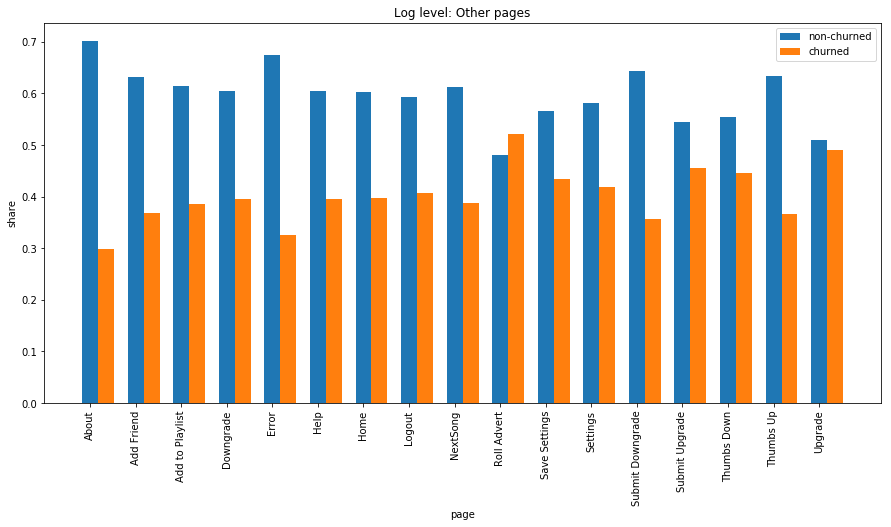

In [75]:
# Split data by churn
df0 = page_avg_df[page_avg_df.churn == 0].sort_values(['page', 'churn']).copy()
df1 = page_avg_df[page_avg_df.churn == 1].sort_values(['page', 'churn']).copy()

label_names = ['non-churned', 'churned']

# Plot
set_plot_size(15, 7);
width = 0.35
labels = df0['page'].sort_values()
plt.xticks(range(len(labels)), labels)
plt.xlabel('page')
plt.ylabel('share')
plt.bar(np.arange(len(df0)), df0['share'], width=width)
plt.bar(np.arange(len(df1))+width, df1['share'], width=width)
plt.xticks(rotation = 90);
ax = plt.gca()
ax.set_title('Log level: Other pages');
plt.legend(label_names, loc=1)
plt.show()

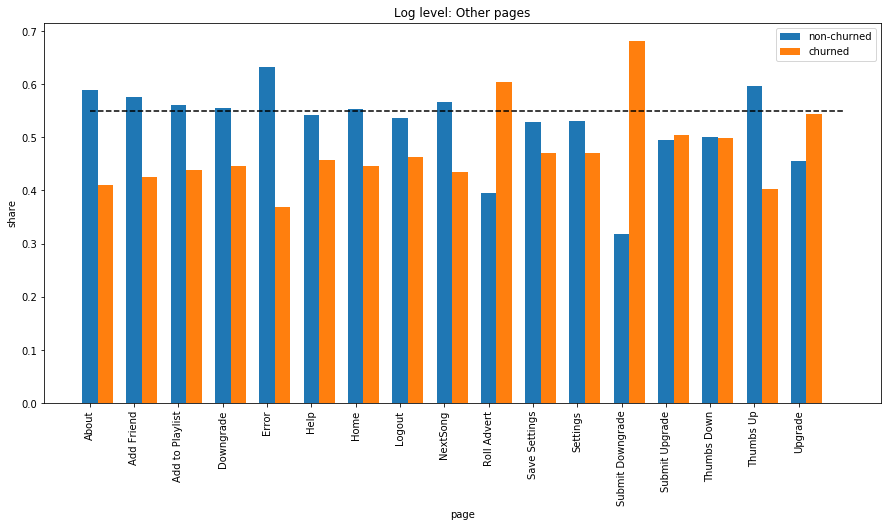

In [84]:
# Split data by churn2
df0 = page_avg_df2[page_avg_df2.churn2 == 0].sort_values(['page', 'churn2']).copy()
df1 = page_avg_df2[page_avg_df2.churn2 == 1].sort_values(['page', 'churn2']).copy()

label_names = ['non-churned', 'churned']

# Plot
set_plot_size(15, 7);
width = 0.35
labels = df0['page'].sort_values()
plt.xticks(range(len(labels)), labels)
plt.xlabel('page')
plt.ylabel('share')
plt.bar(np.arange(len(df0)), df0['share'], width=width)
plt.bar(np.arange(len(df1))+width, df1['share'], width=width)
plt.xticks(rotation = 90);
ax = plt.gca()
ax.set_title('Log level: Other pages');
plt.legend(label_names, loc=1)
plt.hlines(y=0.55, xmin=0.0, xmax=17, linestyles='dashed')
plt.show()

In [719]:
def calc_page_avg(churn_col):
    return data \
        .groupby(churn_col, 'userId', 'page') \
        .count() \
        .groupby(churn_col, 'page') \
        .avg() \
        .select(churn_col, 'page', col('avg(count)').alias('avg')) \
        .sort(churn_col) \
        .toPandas()

In [720]:
page_avg_churn_df = calc_page_avg('churn')

In [721]:
page_avg_churn_df

,churn,page,avg
0,0,Save Settings,2.470588
1,0,Submit Downgrade,1.350000
2,0,NextSong,1108.173410
3,0,Add Friend,22.475309
4,0,Error,2.315789
5,0,About,3.540323
6,0,Add to Playlist,33.260606
7,0,Thumbs Up,62.894118
8,0,Thumbs Down,13.225806
9,0,Help,8.154362


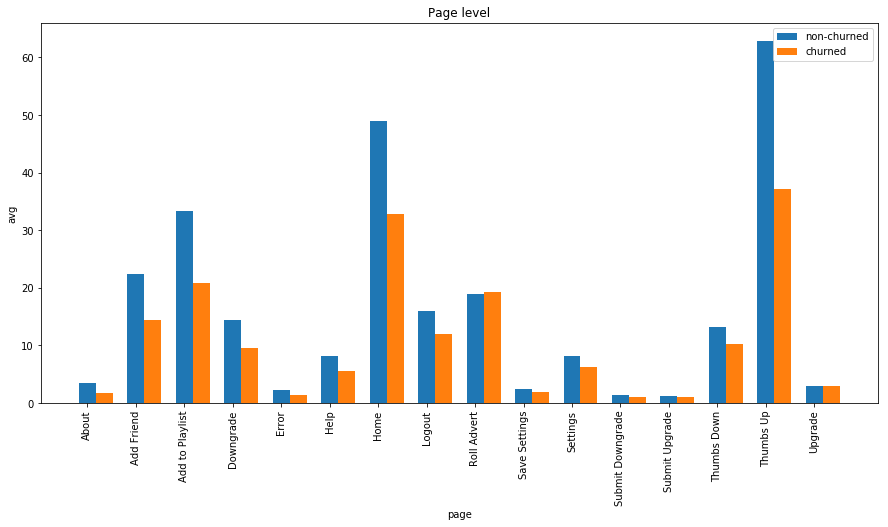

In [726]:
# Split data by churn
df0 = page_avg_churn_df[(page_avg_churn_df.churn == 0) & \
                        (~page_avg_churn_df.page.isin(['NextSong', 'Cancel', 'Cancellation Confirmation']))].sort_values(['page', 'churn']).copy()
df1 = page_avg_churn_df[(page_avg_churn_df.churn == 1) & \
                        (~page_avg_churn_df.page.isin(['NextSong', 'Cancel', 'Cancellation Confirmation']))].sort_values(['page', 'churn']).copy()

label_names = ['non-churned', 'churned']

# Plot
set_plot_size(15, 7);
width = 0.35
labels = df0['page'].sort_values()
plt.xticks(range(len(labels)), labels)
plt.xlabel('page')
plt.ylabel('avg')
plt.bar(np.arange(len(df0)), df0['avg'], width=width)
plt.bar(np.arange(len(df1))+width, df1['avg'], width=width)
plt.xticks(rotation = 90);
ax = plt.gca()
ax.set_title('Page level');
plt.legend(label_names, loc=1)
plt.show()

In [728]:
page_avg_churn_df[page_avg_churn_df.page == 'Thumbs Up']

,churn,page,avg
7,0,Thumbs Up,62.894118
34,1,Thumbs Up,37.180000


In [729]:
page_avg_churn2_df = calc_page_avg('churn2')

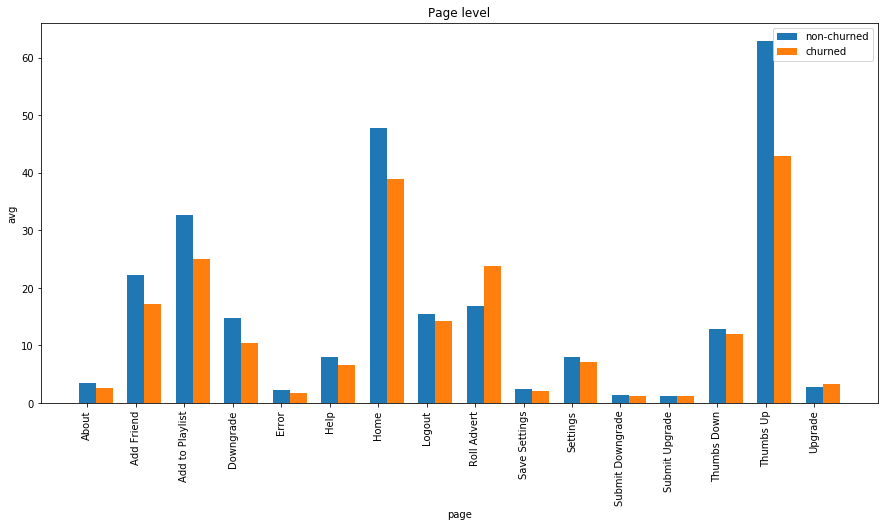

In [733]:
# Split data by churn
df0 = page_avg_churn2_df[(page_avg_churn2_df.churn2 == 0) & \
                        (~page_avg_churn2_df.page.isin(['NextSong', 'Cancel', 'Cancellation Confirmation']))] \
        .sort_values(['page', 'churn2']).copy()
df1 = page_avg_churn2_df[(page_avg_churn2_df.churn2 == 1) & \
                        (~page_avg_churn2_df.page.isin(['NextSong', 'Cancel', 'Cancellation Confirmation']))] \
        .sort_values(['page', 'churn2']).copy()

label_names = ['non-churned', 'churned']

# Plot
set_plot_size(15, 7);
width = 0.35
labels = df0['page'].sort_values()
plt.xticks(range(len(labels)), labels)
plt.xlabel('page')
plt.ylabel('avg')
plt.bar(np.arange(len(df0)), df0['avg'], width=width)
plt.bar(np.arange(len(df1))+width, df1['avg'], width=width)
plt.xticks(rotation = 90);
ax = plt.gca()
ax.set_title('Page level');
plt.legend(label_names, loc=1)
plt.show()

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.